# 9.6 Lab: Support Vector Machines

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import json
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

In [4]:
# support function to plot the decision boundary of svc and highlight the support vectors
def plot_decision_boundary(svc, X, y, h=0.021, pad=0.21):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    # highlight the support vectors
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='*', s=21, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

## 9.6.1 Support Vector Classifier

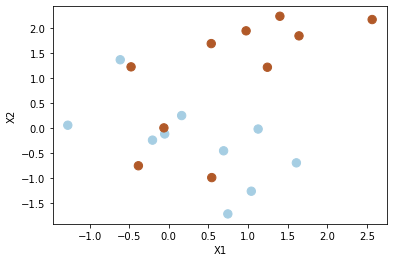

In [5]:
# we start from generating random dataset: following the bookm we generate a dataset with 20 observations,
# 2 features. And we divide these into two classes.
# set seed 
np.random.seed(21)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 1

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

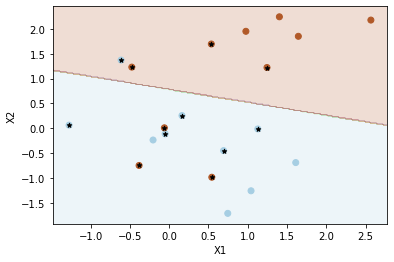

Number of support vectors:  12


In [6]:
# Support Vector Classifier (i.e. support vector machine with linear kernel)
svc1 = SVC(C= 10, kernel='linear')
svc1.fit(X, y)

plot_decision_boundary(svc1, X, y)

In [7]:
# as mentioned before, we could use dir() to see the methods of the class
# I did not find a good way to print out the summary of the SVC model.
dir(svc1)

['C',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_more_tags',
 '_n_support',
 '_num_iter',
 '_probA',
 '_probB',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predict',
 '_sparse_pr

In [8]:
# we could take a look at the defaul parameters of the SVC model
svc1.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

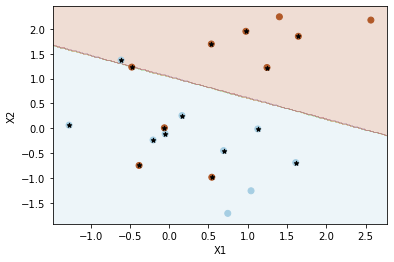

Number of support vectors:  16


In [9]:
# we use a small cost (c = 0.1). A smaller value of the cost parameter is being used, 
# we obtain a larger number of support vectors, because the margin is now wider. 
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)

plot_decision_boundary(svc2, X, y)


In [10]:
# we could also try to tune the cost parameter (C) of the SVC model using GridSearchCV
# in this function, we need to specify cross validation folds and the metric to use for evaluation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
clf.cv_results_

{'mean_fit_time': array([0.00064266, 0.00054042, 0.00055275, 0.00059083, 0.00084674,
        0.00112627, 0.0055191 ]),
 'std_fit_time': array([2.24786222e-04, 1.90886944e-05, 1.69841069e-05, 5.96523523e-05,
        3.02563684e-04, 5.95491069e-04, 5.51632458e-03]),
 'mean_score_time': array([0.00042295, 0.00038519, 0.00038064, 0.0003711 , 0.00037973,
        0.00039186, 0.00038993]),
 'std_score_time': array([1.21307457e-04, 1.95654950e-05, 1.80840924e-05, 1.66488054e-05,
        6.12513060e-06, 1.01993005e-05, 1.52062652e-05]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split2_test_score': array([0.5, 0.5, 0

In [11]:
# let us see the best parameters. 
# This is different from the results in the book, it is very likely due to the random generation of the datasetof the data
clf.best_params_

{'C': 1}

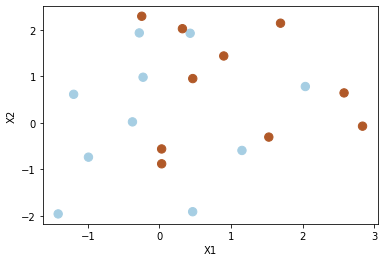

In [12]:
# we use the same generation process to generate test data
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 1

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [13]:
# train a model with the optimal parameters
svc3 = SVC(C=1, kernel='linear')
svc3.fit(X, y)

y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,6,4
1,4,6


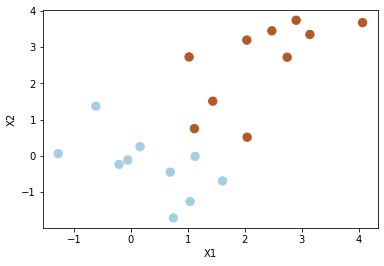

In [14]:
# now we make our data linear separable. In the book, they add another 0.5 to seperate the data. 
# here we start from the data generation process to aviod confusion.
np.random.seed(21)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 2.5

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

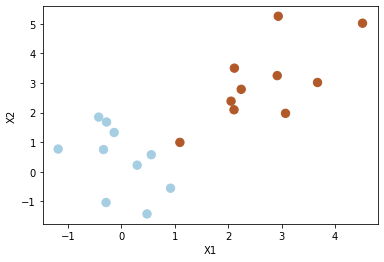

In [15]:
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 2.5

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

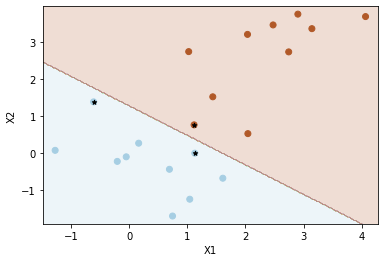

Number of support vectors:  3


In [16]:
# here seems the data is linear separable. We could use a bigger cost parameter (C = 100) to train the model.
svc4 = SVC(C=100, kernel='linear')
svc4.fit(X, y)

plot_decision_boundary(svc4, X, y)

In [17]:
y_pred = svc4.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc4.classes_, columns=svc4.classes_)

,-1,1
-1,8,2
1,0,10


## 9.6.2 Support Vector Machine

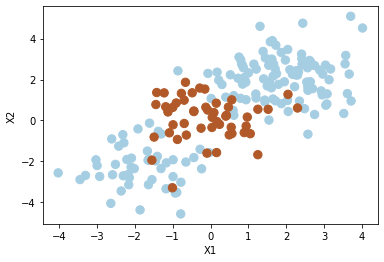

In [18]:
# generating random dataset
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [19]:
# in python, we can use the same svc model abd kernel to specific the kernel
# for rbf kernel, we need to specify the gamma parameter
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(gamma=1)

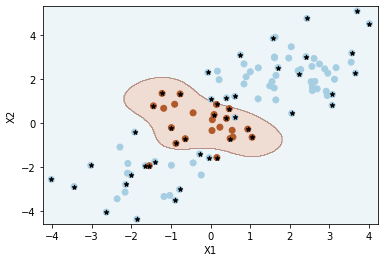

Number of support vectors:  47


In [20]:
plot_decision_boundary(svm, X_train, y_train)

In [21]:
y_pred = svm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svm.classes_, columns=svm.classes_)

,-1,1
-1,70,3
1,12,15


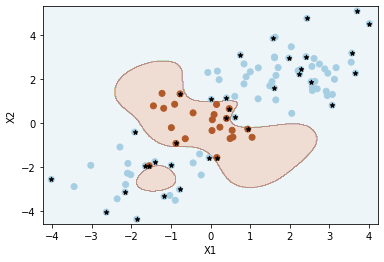

Number of support vectors:  35


In [22]:
# increasing C parameter which increases more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)
plot_decision_boundary(svm2, X_train, y_train)

In [23]:
"""
The above decision boundary seems overfitting. We can compute the test accuracy of the model to
see whether that is the case. 

The model (c = 1) yields a test accuracy of 0.85; the model(c = 100) yields a test accuracy of 0.77.
"""
y_pred = svm2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svm2.classes_, columns=svm2.classes_)

,-1,1
-1,63,10
1,13,14


In [24]:
# set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([0.00091703, 0.00081537, 0.00088799, 0.00092874, 0.00093338,
        0.00076287, 0.00080955, 0.0009871 , 0.00105417, 0.00103793,
        0.00070982, 0.0008008 , 0.00113723, 0.0011848 , 0.0011642 ,
        0.00069854, 0.00079517, 0.00106518, 0.00124123, 0.00127251,
        0.00066621, 0.00079002, 0.00103886, 0.00119874, 0.00118639]),
 'std_fit_time': array([2.70395199e-04, 6.17645360e-05, 7.95419016e-05, 5.39760075e-05,
        4.94009337e-05, 5.19790834e-05, 3.18090506e-05, 5.62723206e-05,
        5.75105200e-05, 5.54374416e-05, 5.86244864e-05, 6.57596995e-05,
        6.75010494e-05, 1.26474268e-04, 9.78526895e-05, 3.42851305e-05,
        4.41099888e-05, 6.19477402e-05, 7.77099346e-05, 7.08549412e-05,
        5.79842660e-05, 6.85731127e-05, 7.82369069e-05, 8.74511061e-05,
        7.35110983e-05]),
 'mean_score_time': array([0.00046995, 0.00040393, 0.00043306, 0.00041425, 0.00040598,
        0.00039973, 0.0003891 , 0.0004117 , 0.0004153 , 0.00039673,
        0.00

In [25]:
# let us see the best parameters.
clf.best_params_

{'C': 1, 'gamma': 0.5}

In [26]:
# confusion matrix for the best model
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[69,  4],
       [11, 16]])

In [27]:
# calculate the test accuracy
clf.best_estimator_.score(X_test, y_test)

0.85

## 9.6.3 ROC Curves

In [28]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

# we train another model flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

' \nFrom the plots below, we can see that the model with gamma = 50 is overfitting the training data \n(i.e. the training metric is much better than the test metric).\n'

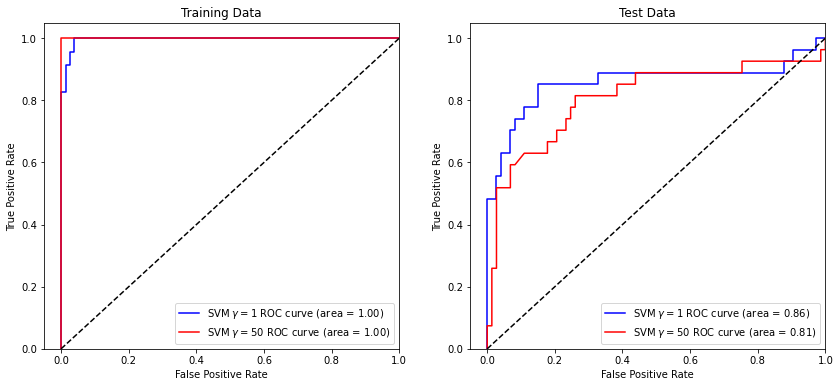

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

""" 
From the plots below, we can see that the model with gamma = 50 is overfitting the training data 
(i.e. the training metric is much better than the test metric).
"""

## 9.6.4 SVM with Multiple Classes

Text(0, 0.5, 'XX2')

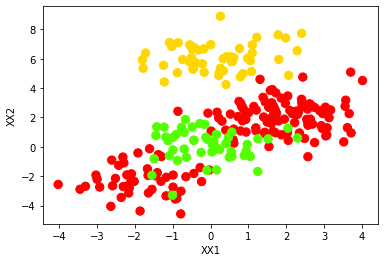

In [30]:
# generate the previously used random dataset
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

# adding another class to the dataset, I used a different offset to separate the classes better
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy==0, 1] = XX[yy==0, 1] + 6

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2')

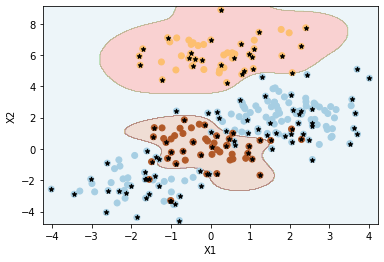

Number of support vectors:  123


In [31]:
# fit the svm model 
svm5 = SVC(C=10, kernel='rbf', gamma=1)
svm5.fit(XX, yy)
plot_decision_boundary(svm5, XX, yy)

## 9.6.5 Application to Gene Expression Data

In [32]:
# I saved the gene expression data as a json file, in python we could load the json file using the json library
# after reading in the data, we can use the data is same as a dictionary, we can use the keys to access the data
# import json
!wget https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/ -N
f = open('Khan.json',)
Khan = json.load(f)
print(Khan.keys())

--2022-08-15 13:31:18--  https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2022-08-15 13:31:18 ERROR 400: Bad Request.

dict_keys(['xtrain', 'xtest', 'ytrain', 'ytest'])


In [33]:
X_train = np.array(Khan['xtrain'])
y_train = np.array(Khan['ytrain'])
X_test = np.array(Khan['xtest'])
y_test = np.array(Khan['ytest'])

In [34]:
# take a look at the data, we will notice there are 4 classes
np.unique(y_train)

array([1, 2, 3, 4])

In [35]:
svm6 = SVC(C = 10, kernel='linear')
svm6.fit(X_train, y_train)

SVC(C=10, kernel='linear')

In [36]:
""" 
We see below that the model is perfect on training data. In fact, this is not surprising, 
because the large number of variables relative to the number of observations implies that 
it is easy to find hyperplanes that fully separate the classes. We are most interested not 
in the support vector classifier’s performance on the training observations, but rather its 
performance on the test observations.
"""
print('train accuracy', svm6.score(X_train, y_train))
y_pred = svm6.predict(X_test)
print('test accuracy', svm6.score(X_test, y_test))

train accuracy 1.0
test accuracy 0.9


In [37]:
# End of Chapter 9